   Unnamed: 0        Date  AveragePrice  Total Volume     4046       4225  \
0           0  2015-12-27          1.33      64236.62  1036.74   54454.85   
1           1  2015-12-20          1.35      54876.98   674.28   44638.81   
2           2  2015-12-13          0.93     118220.22   794.70  109149.67   
3           3  2015-12-06          1.08      78992.15  1132.00   71976.41   
4           4  2015-11-29          1.28      51039.60   941.48   43838.39   

     4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
0   48.16     8696.87     8603.62       93.25          0.0  conventional   
1   58.33     9505.56     9408.07       97.49          0.0  conventional   
2  130.50     8145.35     8042.21      103.14          0.0  conventional   
3   72.58     5811.16     5677.40      133.76          0.0  conventional   
4   75.78     6183.95     5986.26      197.69          0.0  conventional   

   year  region  
0  2015  Albany  
1  2015  Albany  
2  2015  Albany  
3  2015 

C:\Users\Brendan Haas\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


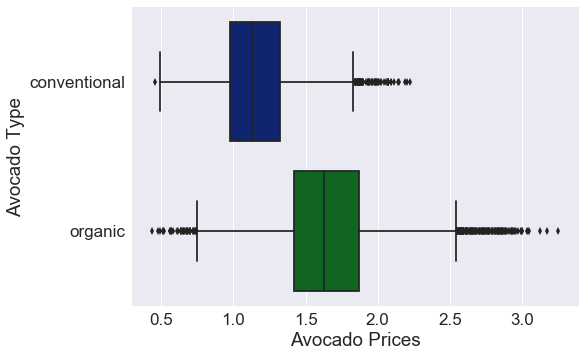

In [91]:
#Avocado Prices Data Visualization

#Import Statements
import numpy as np 
import pandas as pd 
import seaborn as sns
import sys
import matplotlib.pyplot as plt
#from fbprophet import Prophet

#Read in data
data = pd.read_csv('avocado.csv')

#Get a basic view of what the data looks like
print(data.head())

#Check if we have any missing values in our data set
print(data.isnull().sum())
#Fortunately, this is very good data with no missing values!

#See what type of avocados we have
data.groupby('type').groups

#We saw we had two types of avocados: Conventional and Organic
#Which is more expensive?
AvocadoTypes = sns.boxplot(y='type', x='AveragePrice', data=data, palette = 'dark')
AvocadoTypes.set(ylabel='Avocado Type', xlabel = 'Avocado Prices')
plt.show()
#So we can see organic avocados are more expensive, as expected

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


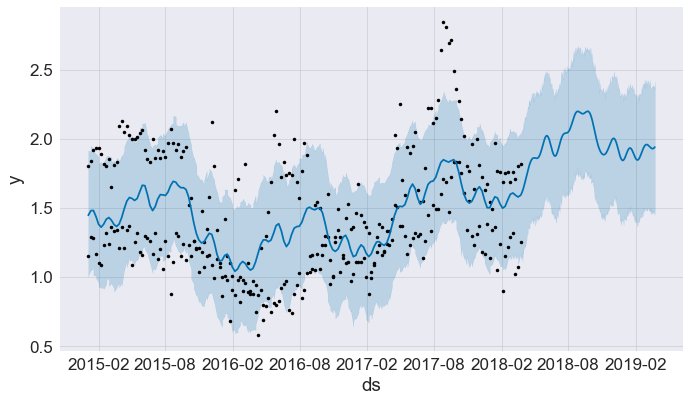

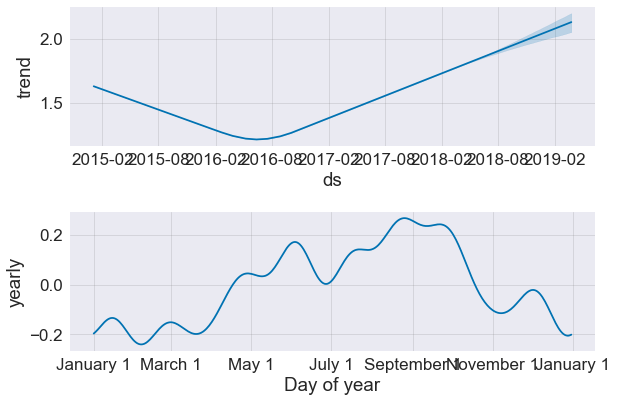

In [92]:
#Let's use the fbprophet package to predict future avocado prices
from fbprophet import Prophet

#Create a new prophet object
P = Prophet()

#Select only the price and date portions of the data set
#Since I live in St. Louis, let's focus on prices in St. Louis
Regions = data.groupby(data.region)
StLouisPrices = Regions.get_group('StLouis')[['Date', 'AveragePrice']].reset_index(drop=True)
#Package needs the x and y columns named as 'ds' and 'y' to work
StLouisPrices = StLouisPrices.rename(columns={'Date':'ds', 'AveragePrice':'y'})

#Use prophet on the St. Louis data
P.fit(StLouisPrices)
#Look one year into the future
Future = P.make_future_dataframe(periods=365)
Forecast = P.predict(Future)
Forecast.tail()
StLouisPricesPlot = P.plot(Forecast)
plt.show()

#Print future predictions
Forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#Here we can see what components are accounting for the prediction values
StLouisPricesComponents = P.plot_components(Forecast)
plt.show()
#So we see prices have generally gone up since 2016, but variability is largely due to the time of year
#Prices seem to get highest in the fall, if you want cheap avocados, buy around the start of the new year!



C:\Users\Brendan Haas\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


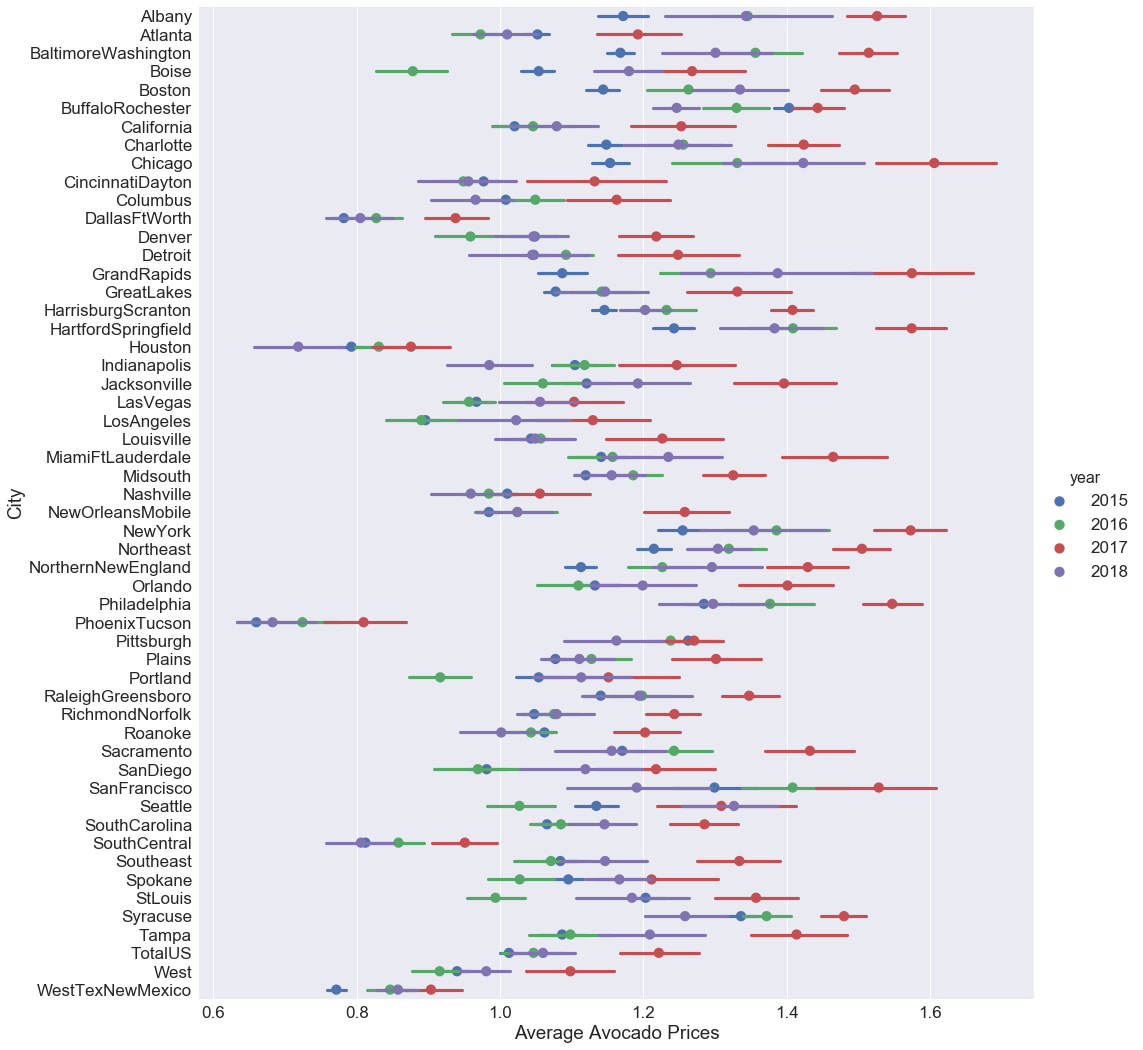

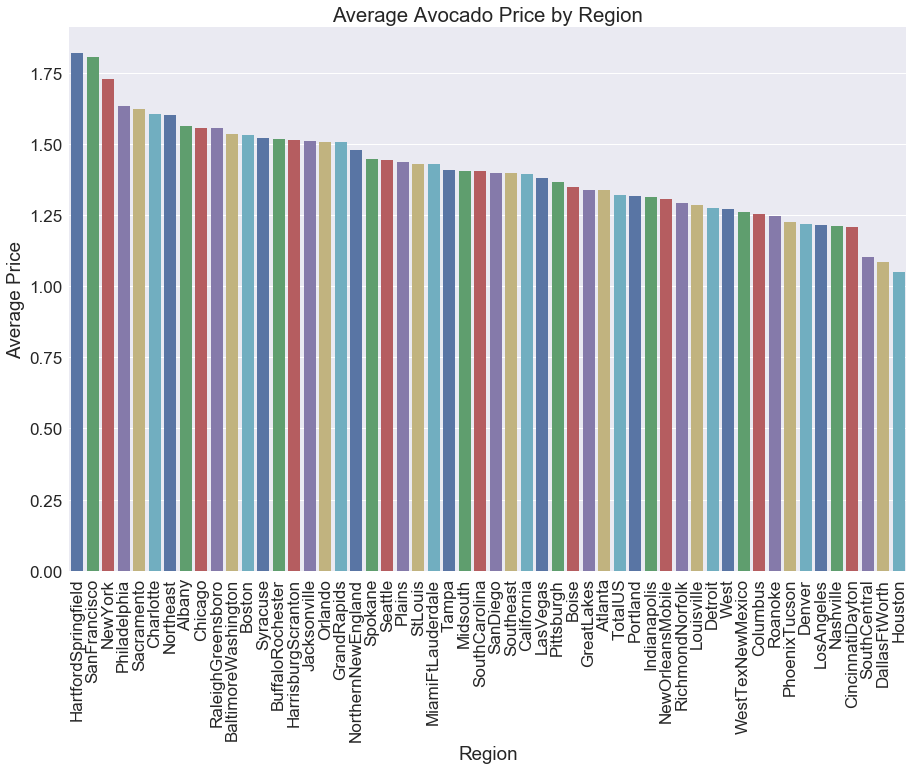

In [93]:
#Maybe prices elsewhere are low enough that we should travel to pick up avocados?
#Let's plot the prices for each location in the dataset
mask = data['type'] == 'conventional'
AvocadosAcrossRegions = sns.factorplot('AveragePrice','region',
                   data=data[mask], #Only look at conventional avocados
                   hue='year', #We'll plot each year in the dataset
                   size=15,
                   aspect=1.0,
                   palette='deep',
                   join=False, #Don't draw lines between points from the same year
                   legend_out=True #Draw legend outside plot, located center right
              )
AvocadosAcrossRegions.set(ylabel='City', xlabel = 'Average Avocado Prices')
plt.show()

#We see that prices seem lower closer to the Mexican border
#This makes sense given the number of Hass avocados produced in Mexico!


#We can also make a simpler plot, where year is not accounted for
#We'll simply take the average price for each region
RegionList=list(data.region.unique()) #Grab each region

#Calculate the average price for each region
AveragePrice=[]
for i in RegionList:
    RegionData=data[data.region==i]
    RegionAverage=sum(RegionData.AveragePrice)/len(RegionData)
    AveragePrice.append(RegionAverage)

#Organize the data from highest cost to lowest
DFRegionPrice=pd.DataFrame({'RegionList':RegionList,'AveragePrice':AveragePrice})
NewIndex=DFRegionPrice.AveragePrice.sort_values(ascending=False).index.values
SortedData=DFRegionPrice.reindex(NewIndex)

#Plot the data
plt.figure(figsize=(15,10))
AvocadoPricesByRegion=sns.barplot(x=SortedData.RegionList,y=SortedData.AveragePrice,palette='deep')
AvocadoPricesByRegion.set(ylabel='Average Price', xlabel = 'Region', title = 'Average Avocado Price by Region')
plt.xticks(rotation=90) #Rotate region names 90 degrees so they don't overwrite each other on the plot
plt.show()

#This plot makes it even more obvious that closer to the southern boarder, avocado prices are lower

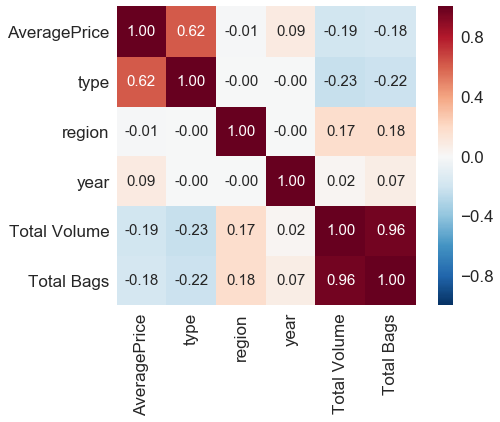

In [94]:
#What are the main factors driving the prices of avocados in the United States, besides the time of year?
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
dicts = {}

#First we need to transform the data from 'type' and region', which are both strings, to the proper form
LE.fit(data.type.drop_duplicates()) 
dicts['type'] = list(LE.classes_)
data.type = LE.transform(data.type)

LE.fit(data.region.drop_duplicates())
dicts['region'] = list(LE.classes_)
data.region = LE.transform(data.region)

#Plot how correlated each characteristic is
columns = ['AveragePrice','type', 'region', 'year','Total Volume','Total Bags']
cm = np.corrcoef(data[columns].values.T)
sns.set(font_scale = 1.7)
hm = sns.heatmap(cm,cbar = True, annot = True,square = True, fmt = '.2f', annot_kws = {'size':15}, yticklabels = columns, xticklabels = columns)
plt.show()
#So we see that price is mostly determined by the avocado type, though total avocados sold and the year have smaller effects
#As a sanity check, we see 'Total Bags' and 'Total Volume' are very closely correlated, as we'd expect